# A guide to apply POD to the data of Nek5000 simulations

 Saleh Rezaeiravesh and Philipp Schlatter,<br/> 
 salehr@mech.kth.se, pschlatt@mech.kth.se <br/>
 SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Stockholm, Sweden
___

This is a short notebook to show how we can construct a POD from the snapshots of a quantity of interest (QoI) generated from a Nek5000 simulation. 

A truncated POD for a field $u(\mathbf{x},t)$ is written as, 

$$
u(\mathbf{x},t) = \sum_{k=1}^{K} a_k(t) \varphi_k(\mathbf{x}) \,,
$$
where $K$ is not greater than the minimum of the the number of snapshots and number of spatial points.


In the **snapshot POD** which is more frequently used in fluid mechanics, the number of snapshots (in time) are much smaller than the spatial points. 
For this type of POD, $\varphi_k(\mathbf{x})$ is the $k$-th basis function in space with associated $a_k(t)$ temporal coefficients. 


In this notebook, two methods for constructing a snapshot POD, which are, however, essentially identical are tested by applying them to a set of simulation data obtained from Nek5000. The methods are:
 1. **Eigenvalues and eigenvectors of the covariance function of the snapshot matrix,**
 2. **Singular Value Decomposition (SVD).**

There are a few resources which are recommended to gain more theoretical background on POD:
* [The tutorial by J. Weiss](https://depositonce.tu-berlin.de/bitstream/11303/9456/5/podnotes_aiaa2019.pdf)
* [Lecture 1](https://www.youtube.com/watch?v=YX24Jgd90uY), [lecture 2](https://www.youtube.com/watch?v=X5GhhjpX0ao), and [lecture 3](https://www.youtube.com/watch?v=sK0cUVD7mxw) by Nathan Kutz.

## Dependencies
* For reading the `Nek5000` simulation data, we use [`pymech`](https://github.com/eX-Mech/pymech). 
* After reading the data by `pymech`, the library [`pickle`](https://docs.python.org/3/library/pickle.html) is used to store a compressed binary file made up of the snapshots of the chosen QoIs. This step is optional, however, it will speedup importing the data.
* The POD is implemented using `numpy`.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import matplotlib.pylab as pylab
params = {'legend.fontsize': 15,
          'legend.loc':'best',
          'figure.figsize': (15, 5),
         'lines.markerfacecolor':'none',
         'axes.labelsize': 17,
         'axes.titlesize': 17,
         'xtick.labelsize':15,
         'ytick.labelsize':15,
         'grid.alpha':0.6}
pylab.rcParams.update(params)
#
from pymech import dataset
import pickle
#local modules
sys.path.append('./modules_pod/')
from nek_snaps import dbCreator,dbReader,massMatrixReader
from plotters import contour2d,scatter

## Read the snapshots  by `pymech` and create an `pickle` database 
* Set the path to the `Nek5000` case where `*.f` files are stored.
To test, the snapshots of a planar mixing layer can be downloaded from [this link](https://kth.box.com/s/x92r0z6dmfyz5m8ki8prbxnigw15u58p).
* If `doPickle` is `True`, then a `pickle` database from the `*.f` files in a user-specified range of a snapshots is created. This should be done once, unless the settings change. Therefore, when repeating the POD construction using the same data, make `doPickle` `False`. This leads to a good speed up in reading the snapshot data.

In [2]:
#------- SETTINGS -------------------------------------
#Path to the *.f files created by Nek5000
#Change path_ to where the data are downloaded.
path_="./mixlay2d_snaps/"

caseName='mixlay'  #Nek case name

doPickle=False  #if True, a pickle database from Nek data is created
if doPickle:
   qoiName=['temperature','pressure','ux','uy']   #list of QoIs whose data to be read
   #range of snapshots to be included in the DB
   start_=1   #ID of the starting file, e.g. 5 -> caseName0.f00005
   end_=215     #ID of the end file
#-----------------------------------------------------

#Create a pickle database or read an already existing pickle database
if doPickle:
   info={'dataPath':path_,
         'caseName':caseName,
         'startID':start_,
         'endID':end_,
         'qoiName':qoiName}
   dbQoI=dbCreator(info)
else:    
   pickleFileName='mixlay_1to215' 
   info={'pickleFile':path_+pickleFileName}    
   dbQoI=dbReader(info)

Let's see what keys and values are available in the `dbQoI`:

In [3]:
print('Keys in QoI-db: ',dbQoI.keys())
print('Keys in db of a QoI',dbQoI['temperature'].keys())
print('Starting and end file included the db: %s to %s.' %(dbQoI['temperature']['startFile'],dbQoI['temperature']['endFile']))

Keys in QoI-db:  dict_keys(['temperature', 'pressure', 'ux', 'uy', 'massMat'])
Keys in db of a QoI dict_keys(['snapDB', 'qoiName', 'nSnap', 'dims', 'x', 'y', 'nx', 'ny', 'creationDate', 'startFile', 'endFile', 'sourceData'])
Starting and end file included the db: mixlay0.f00001 to mixlay0.f00216.


## Read the mass matrix of the grid

Read the mass matrix $\mathbf{M}$ associated to the grid points of the Nek5000 simulation. Note that we assume the mass matrix reamined unchanged in time. 

In [4]:
#M: mass matrix of Nek5000 simulation
bm1=dbQoI['massMat']['val']
bmsq=np.sqrt(bm1).flatten('F')

## Extract the required data from the database

Now we should grab the snapshot data of the QoI from the database. The QoI name is set via `qoiName`. If the QoI is a vector, like velocity, the snapshots of the associated components are read separately and then get concatenated. 

In [5]:
#QoI(s) for which POD is to be constructed
qoiName='velocity'   #'temperature', 'pressure', 'velocity'

Two important points:

* The snapshots of any scalar is a 3D numpy array of shape `(nx,ny,m)`. We should reduce the spatial dimensions into one. The method for this purpose is not important, but a consistent reverse rule should be applied later for plotting the field reconstructed from the POD modes. The new shape of `U` array will be `(n,m)` where `n=nx*ny` for a scalar QoI and `n=2*nx*ny` for a 2D velocity field (extension to a 3D flow is straightforward). Also `m` is the number of snapshots which are assumed here to be associated to equidistant time samples.

* The read-in snapshot data are multiplied by $\mathbf{M}^{1/2}$, considering the GLL points are non-equidistant. Therefore, POD will be constructed using $\mathbf{M}^{1/2}\mathbf{U}$. This is needed to ensure that orhogonalization of the POD bases is with resect to weight $\mathbf{M}$. Henceforth, by orthogonalization/orthonormalization and norms, an assoiated weighted version is meant. 

In [6]:
if qoiName=='temperature' or qoiName=='pressure':   #scalar QoI
   #grab the snapshots 
   db=dbQoI[qoiName]
   U=db['snapDB']
   nx,ny,m=U.shape
   #rehshape snapshot matrix to (nx*ny,m)
   U=np.reshape(U,(nx*ny,m),order='F')   #snapshot data       
   #multiply snapshots by M^1/2
   for i in range(m): U[:,i]*=bmsq       
        
elif qoiName=='velocity':   #velocity vector
   #grab the snapshots 
   db =dbQoI['ux']       
   nx,ny,m=dbQoI['ux']['snapDB'].shape
   #rehshape snapshot matrix to (nx*ny,m)
   ux=np.reshape(dbQoI['ux']['snapDB'],(nx*ny,m),order='F')
   uy=np.reshape(dbQoI['uy']['snapDB'],(nx*ny,m),order='F')   
   #multiply snapshots by M^1/2
   for i in range(m): ux[:,i]*=bmsq
   for i in range(m): uy[:,i]*=bmsq
   #concatenate samples of velocity components: U=[ux|uy] 
   U=np.concatenate([ux,uy],axis=0)   
    
print('shape of U: (n,m)=',U.shape)    

shape of U: (n,m)= (76800, 215)


Let's get the coordinates of the spatial points for contour plots in the post-processing step. 

In [7]:
x=db['x']        #x-ccordinate
y=db['y']        #y coordinate
nxy=nx*ny          #total number of spatial points    
print('nx*ny = ',nxy)

nx*ny =  38400


One can (optionally) first subtract the mean (of the snapshots) from the data:

In [8]:
#snapMean_=np.mean(U,axis=1)
#for i in range(m):
#   U[:,i]-=snapMean_

## POD, Method 1: Eigenvalues of the Covariance Matrix
**Step 1:** Construct the covariance matrix $\mathbf{C}=\frac{1}{m}\mathbf{U}^T\mathbf{U}$. This matrix is $m\times  m$ meaning that the correlations are found by averaging over space. 

In [9]:
C=(U.T @ U)/m
print('covMatrix shape: ',C.shape)

covMatrix shape:  (215, 215)


Here is the structure of $\mathbf{C}$. What do you think about its properties?

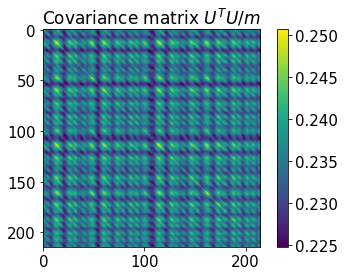

In [10]:
plt.imshow(C)
plt.colorbar()
plt.title(r'Covariance matrix $U^TU/m$')
plt.show()

**Step 2:** Find the eigenvalues and eigenvectors of $\mathbf{C}$. Then sort the eigenvalues in a descending order and sort the eigenvectors accordingly.
$$
\mathbf{C}\mathbf{A} = \mathbf{A} \mathbf{\Lambda}
$$

  * The array of eigenvectors, $\mathbf{A}$ has the dimension of $m\times m$. The $i$-th column of this array contains the eigenvector corresponding to the $i$-th eigenvalue. 
$$
\mathbf{A}=\left[\mathbf{a}_1 | \mathbf{a}_2|\cdots|\mathbf{a}_{m}\right]
$$

  * The eigenvectors are orthogonal.
  * When comparing to the SVD method (see below), $\mathbf{A}$ acts as the matrix of temporal coefficients in the POD. 

In [11]:
#eigenvalues and eigenvectors of C
Lam1,A1=la.eig(C)

#sort the eigenvalues and eigenvectors in a descending order
i1=np.argsort(Lam1)
i1=np.flip(i1)
Lam1=Lam1[i1]
A1=A1[:,i1]

Let's see how the sorted eigenvalues vary with the number of modes:

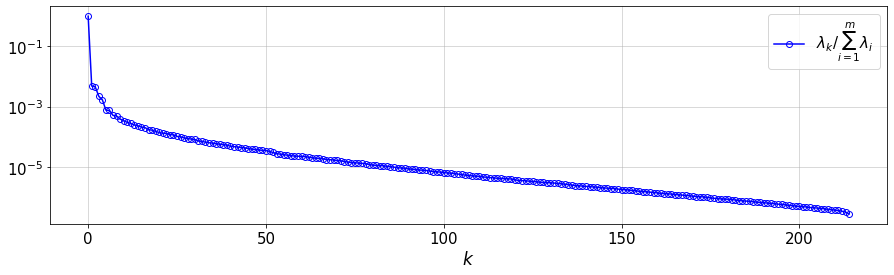

In [12]:
##eigenvalues of C
#print('Eigenvalues:',Lam1)
plt.figure(figsize=(15,4))
plt.semilogy((Lam1)/sum(Lam1),'-ob',label=r'$\lambda_k/\sum_{i=1}^m{\lambda_i}$')
#plt.semilogx(np.cumsum(Lam1)/sum(Lam1),'o-b',label='$\sum_{i=1}^k\lambda_i/\sum_{i=1}^m{\lambda_i}$')
plt.xlabel(r'$k$')
plt.legend(loc='best')
plt.grid()
plt.show()

By examining the eigenvalues and eigenvectors (below), it is clear tha the columns of $\mathbf{A}$ are orthogonal but not orthonormal.

Shape of the eigenvectors array: (215, 215)
||A_0||=1
||A_2||=1
||A_0.A_2||=3.20924e-17


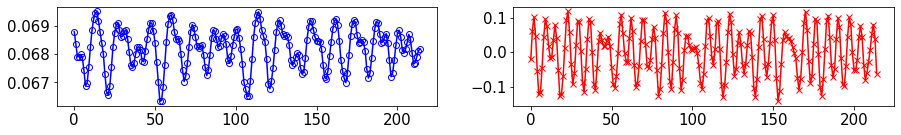

In [13]:
#eigenvctors
print('Shape of the eigenvectors array:',A1.shape)
iMod1=0
iMod2=2
print('||A_%d||=%g' %(iMod1,la.norm(A1[:,iMod1]))) 
print('||A_%d||=%g' %(iMod2,la.norm(A1[:,iMod2]))) 
print('||A_%d.A_%d||=%g' %(iMod1,iMod2,np.dot(A1[:,iMod1],A1[:,iMod2]))) 

plt.figure(figsize=(15,4))
plt.subplot(221)
plt.plot(A1[:,iMod1],'-ob')
plt.subplot(222)
plt.plot(A1[:,iMod2],'-xr')
plt.show()

**Step 3** Now we need to find the spatial modes $\mathbf{\Phi}$. To this, we use the defintion
$$
\mathbf{\Phi} = \mathbf{U} \mathbf{A}\,.
$$
This leads to $\mathbf{\Phi}$ of size $n\times m$. Therefore the columns of $\mathbf{\Phi}$ are the spatial modes in the POD expansion. 

In [14]:
Phi1=U @ A1

In [15]:
#optional: normalization of Phi and recalculation of A (norm of A's columns won't be one anymore)
#for i in range(m):
#    Phi1[:,i]/=la.norm(Phi1[:,i])  
    
#A1=U.T @ Phi1

#print(la.norm(A1[:,0]))
#print(la.norm(Phi1[:n,0]),la.norm(Phi1[:n,0]/bmsq))
#print(la.norm(Phi1[n:,0]),la.norm(Phi1[n:,0]/bmsq))

We can plot any of the spatial modes over the original $x-y$ grid:

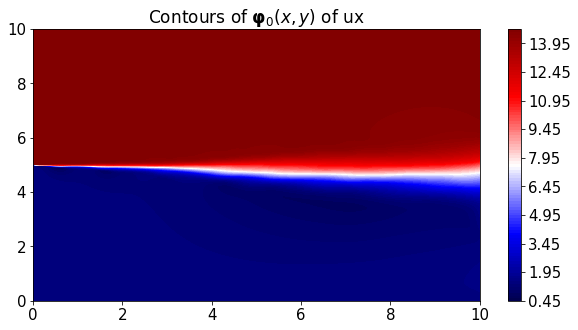

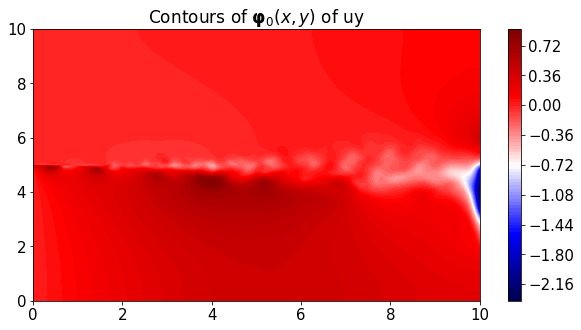

In [16]:
iMod=0
if qoiName=='temperature' or qoiName=='pressure':
   contour2d(Phi1[:,iMod]/bmsq,x,y,title=r'Contours of $\mathbf{\varphi}_%d (x,y)$' %(iMod))
elif qoiName=='velocity':    
   contour2d(Phi1[:nxy,iMod]/bmsq,x,y,title=r'Contours of $\mathbf{\varphi}_%d (x,y)$ of ux' %(iMod))
   contour2d(Phi1[nxy:,iMod]/bmsq,x,y,title=r'Contours of $\mathbf{\varphi}_%d (x,y)$ of uy' %(iMod))   

**Step 4** Now we can reconstruct the field using the POD modes:
$$
\tilde{\mathbf{U}} = \mathbf{\Phi} \mathbf{A}^T
$$
which can be written in the extended format as, 
$$
\tilde{\mathbf{U}} = 
\begin{bmatrix}
\Phi_{1,1} &\Phi_{1,2}&\cdots&\Phi_{1,m} \\
\Phi_{2,1} &\Phi_{2,2}&\cdots&\Phi_{2,m} \\
\cdots & \cdots & \cdots & \cdots\\
\Phi_{n,1} &\Phi_{n,2}&\cdots&\Phi_{n,m} \\
\end{bmatrix}
\begin{bmatrix}
A_{1,1} & A_{2,1} & \cdots & A_{m,1} \\
A_{1,2} & A_{2,2} & \cdots & A_{m,2} \\
\cdots & \cdots & \cdots & \cdots\\
A_{1,m} & A_{2,m} & \cdots & A_{m,m} \\
\end{bmatrix}
$$
Note that the $k$-th row in the second matrix on the RHS of this equation represents the $k$-th eigenvector of $\mathbf{C}$. 


Instead of using the whole $m$ modes when reconstructing $\mathbf{U}$, we can use only $K\leq m$:
$$
\tilde{\mathbf{U}} = \mathbf{\Phi}_{:,1:K} \mathbf{A}^T_{1:K,:}
$$

The reconstructed field $\tilde{\mathbf{U}}$ has dimension of $m\times n$. Therefore, $[\tilde{\mathbf{U}}]_{:,k}$ is the reconstructed field at snapshot $k$ where $k=1,2,\cdots,m$ and hence $[\tilde{\mathbf{U}}]_{:,k}$ can be compared to the observed $k$-th snapshot.

In [17]:
maxMode=6  #maximum mode considered in the reconstruction
uRec1=Phi1[:,:maxMode+1] @ A1[:,:maxMode+1].T

#divide by M^1/2
if qoiName=='temperature' or qoiName=='pressure':
   for i in range(m): uRec1[:,i]/=bmsq
elif qoiName=='velocity':
   for i in range(m): 
       uRec1[:nxy,i]/=bmsq    
       uRec1[nxy:,i]/=bmsq        

Let's plot the original data at snapshot `iSnap` (set below) and compare it with the POD recosntructed field by POD when including the first `maxMode` modes.

In [18]:
iSnap=3    #snapshot id (for comaprison), iSnap<=m

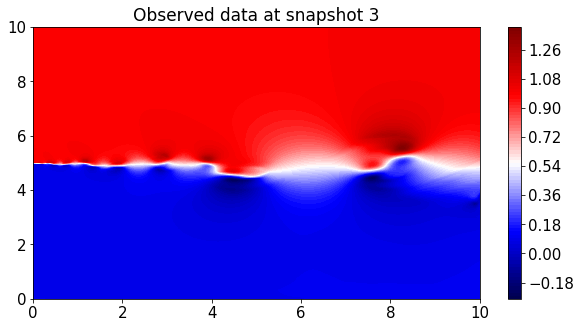

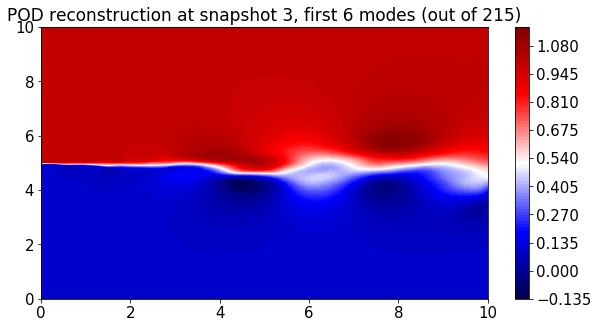

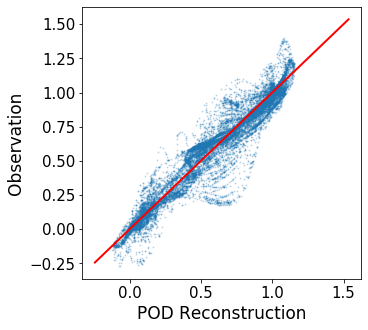

Correlation between the observation and POD reconstruction =  0.9871355654538132


In [19]:
#Observed snapshot 
if qoiName=='temperature' or qoiName=='pressure':
   Uex=U[:,iSnap]/bmsq
   uRec1_=uRec1[:,iSnap]
elif qoiName=='velocity':
   ##ux
   uRec1_=uRec1[:nxy,iSnap]
   Uex=U[:nxy,iSnap]/bmsq
   ##uy 
   #uRec1_=uRec1[n:,iSnap]
   #Uex=U[n:,iSnap]/bmsq
        
#plot    
contour2d(Uex,x,y,title='Observed data at snapshot %d' %iSnap)
title_='POD reconstruction at snapshot %d, first %d modes (out of %d)' %(iSnap,maxMode,m)
contour2d(uRec1_,x,y,title=title_)
#scatter plot
scatter(uRec1_,Uex,xlab='POD Reconstruction',ylab='Observation')

___
___
## POD, Method 2: SVD (Singular Value Decomposition)

For a general overview on SVD, see e.g.:
* [Lecture 1](https://www.youtube.com/watch?v=nbBvuuNVfco) and [lecture 2](https://www.youtube.com/watch?v=rs63fnUWJkk&t=107s) by S. Brunton.

By SVD, the rectangular snapshot matrix $\mathbf{U}$ that is $n\times m$ is decomposed as,
$$
\mathbf{U}=\mathbf{L} \mathbf{\Sigma} \mathbf{R}^T
$$
where, 
* $\mathbf{L}$ is a $n\times n$ unitary matrix (left singular vector of $\mathbf{U}$),
* $\mathbf{\Sigma}$ is a $n\times m$ diagonal matrix with real non-negative diagonal elements (matrix of singular values of $\mathbf{U}$), and
* $\mathbf{R}$ is a $m\times m$ unitary matrix (right singular vector of $\mathbf{U}$). 

Note that,
* If $\mathbf{U}$ is real, then $\mathbf{L}$ and $\mathbf{R}$ are real orthogonal matrices. 
* Typically, $r=\min(m,n)$ non-zero diagonal elements of $\mathbf{\Sigma}$ exists such that
$$
\sigma_1 \geq \sigma_2 \geq \cdots \geq \sigma_r\geq 0
$$
where $\sigma_i=\mathbf{\Sigma}_{ii}$. 
* Clearly, SVD is, in general, a procedure for "diagonalization" of a rectangular matrix. 

**Connection between POD and SVD:**
* Both direct and snapshot PODs can be expressed as a SVD. 
* For instance, for the snapshot POD where $n>m$ (method 1 above) we have:
$$
\mathbf{C}=\frac{1}{m}\mathbf{U}^T\mathbf{U} = 
\frac{1}{m}\mathbf{R} \mathbf{\Sigma}^T \underbrace{\mathbf{L}^T  \mathbf{L}}_{\mathbf{I}}\mathbf{\Sigma}\mathbf{R}^T
=\frac{1}{m}\mathbf{R} \mathbf{\Sigma}^T\mathbf{\Sigma}\mathbf{R}^T
$$
where as compared to $\mathbf{C} = \frac{1}{m}\mathbf{A} \mathbf{\Lambda} \mathbf{A}^T$, shows that $\mathbf{\Lambda}=\frac{1}{m}\mathbf{\Sigma}^T\mathbf{\Sigma}$ which is the connection between the eigenvalues of $\mathbf{C}$ and spectral values of the snapshots.


**Implementation:**

When SVD is called from `numpy.linalg`:
* $\mathbf{\Sigma}$ is a vector of length $m$ containing $\sigma_i$'s. 
* Set `full_matrices=False` to avoid memory shortage and speedup; this results in $\mathbf{L}$ to be $n\times m$.
* In fact $\mathbf{\Phi}=\mathbf{L}$ and columns of $\mathbf{\Phi}$ are orthonormal.
* Therefore, the SVD gives us a natural way for constructing the POD:
$$
\mathbf{U}=\mathbf{\Phi}\mathbf{A}^T = \mathbf{L} \mathbf{\Sigma} \mathbf{R}^T
=\mathbf{L} (\mathbf{R} \mathbf{\Sigma}^T )^T
$$

In [20]:
#SVD
Phi2,Lam2,R2=la.svd(U,full_matrices=False)   

#Note: Columns of Phi2 are orthonormal (weighted by M).

#Multiply bases by M^-1/2
for i in range(m):
    if qoiName=='temperature' or qoiName=='pressure':
       Phi2[:,i]/=bmsq 
    elif qoiName=='velocity':
       Phi2[:nxy,i]/=bmsq     
       Phi2[nxy:,i]/=bmsq     
    
#POD coefficients
A2=R2.T*Lam2 

#optional: normalization of the singular values (to be equal to the eigenvalues in method1)
Lam2=Lam2**2/m   

* **Note 1:** Although the coefficients $\mathbf{A}_2$ are different from $\mathbf{A}_1$, each set is multiplied by the consistent basis functions $\mathbf{\Phi}$, and hence, in the end both methods for constructing POD give the same results. 
* **Note 2:** In method 1 above (i.e. eigenvalue method), the columns of $\mathbf{A}_1$ are orthonormal (with weight $\mathbf{M}$). But in the SVD method, columns of $\mathbf{A}_2$ are orthogonal (with weight $\mathbf{M}$) but their norm is not one. 
* **Note 3:** The $\mathbf{\Phi}$ in the SVD and eigenvalue appoach do not have the same values (due to the difference in normalization), but look the same. In fact, in the SVD method the columns of the spatial modes matrix $\mathbf{\Phi}$ are orthonormal, note that in the above derivaion, $\mathbf{L}^T\mathbf{L}=\mathbf{I}$ (still weighted). However, then we need to multiply the basis by $\mathbf{M}^{-1/2}$ noting that the initial snapshot matrix was multiplied by $\mathbf{M}^{1/2}$.

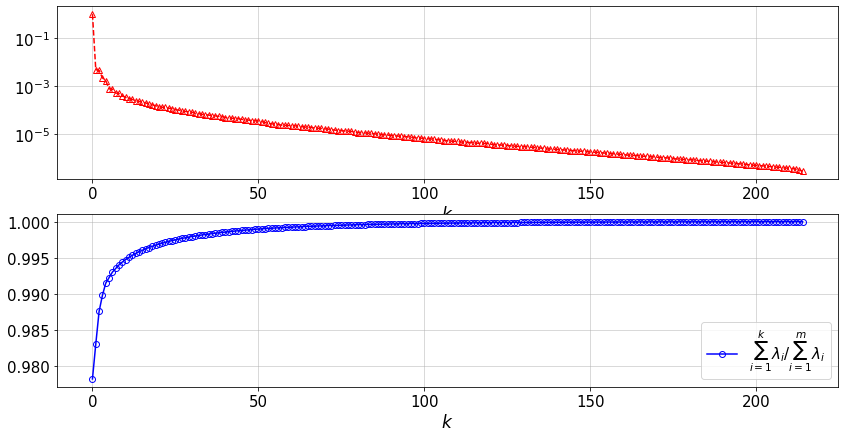

In [21]:
#eigenvalues
#print('Eigenvalues:',Lam2)
plt.figure(figsize=(14,7))
plt.subplot(211)
plt.semilogy((Lam2)/sum(Lam2),'^--r',label=r'$\lambda_k/\sum_{i=1}^m{\lambda_i}$')
plt.xlabel(r'$k$')
plt.grid()
#plt.xlim([0,30])
plt.subplot(212)
plt.plot(np.cumsum(Lam2)/sum(Lam2),'o-b',label='$\sum_{i=1}^k\lambda_i/\sum_{i=1}^m{\lambda_i}$')
plt.xlabel(r'$k$')
plt.legend(loc='best')
plt.grid()
plt.show()

Shape of the eigenvectors array: (215, 215)
||A_0||=104.212
||A_3||=4.95587
||A_0.A_3||=-7.54952e-15


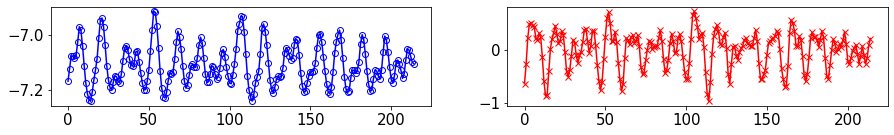

In [22]:
#temporal coeffcients A
print('Shape of the eigenvectors array:',A2.shape)
iMod1=0
iMod2=3
print('||A_%d||=%g' %(iMod1,la.norm(A2[:,iMod1]))) 
print('||A_%d||=%g' %(iMod2,la.norm(A2[:,iMod2]))) 
print('||A_%d.A_%d||=%g' %(iMod1,iMod2,np.dot(A2[:,iMod1],A2[:,iMod2]))) 

plt.figure(figsize=(15,4))
plt.subplot(221)
plt.plot(A2[:,iMod1],'-ob')
plt.subplot(222)
plt.plot(A2[:,iMod2],'-xr')
plt.show()

Contours of the `iMod`-th POD mode(s) are shown below. Note that depending on how the normalization is imposed, the values of the countours may look different than those obtained from the eigenvalue method. But, in any case, the contours look the same.

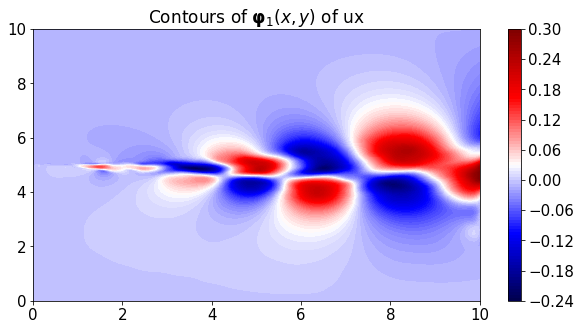

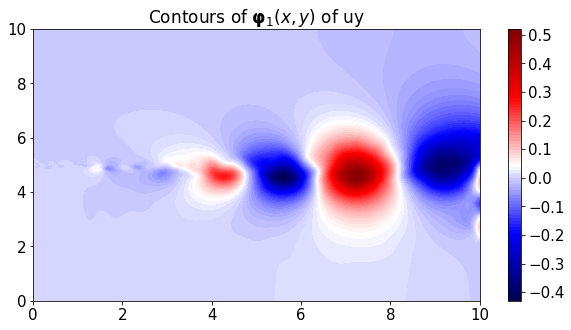

In [23]:
#plot modes
iMod=1
if qoiName=='temperature' or qoiName=='pressure':   
   contour2d(Phi2[:,iMod],x,y,title=r'Contours of $\mathbf{\varphi}_%d (x,y)$' %(iMod))
elif qoiName=='velocity':    
   contour2d(Phi2[:nxy,iMod],x,y,title=r'Contours of $\mathbf{\varphi}_%d (x,y)$ of ux' %(iMod))
   contour2d(Phi2[nxy:,iMod],x,y,title=r'Contours of $\mathbf{\varphi}_%d (x,y)$ of uy' %(iMod))    

The field can be reconstructed using the POD modes:
$$
\tilde{\mathbf{U}} = \mathbf{\Phi} \mathbf{A}^T
$$
Below, `maxMode` specifies the maximum number of modes in the reconstruction. 

In [24]:
#Reconstruct the POD
maxMode=20 #max number of modes in the sum
uRec2=Phi2[:,:maxMode+1] @ A2[:,:maxMode+1].T

At the `iSnap`-th snapshot, construct the POD field and compare it to the actual observation. 

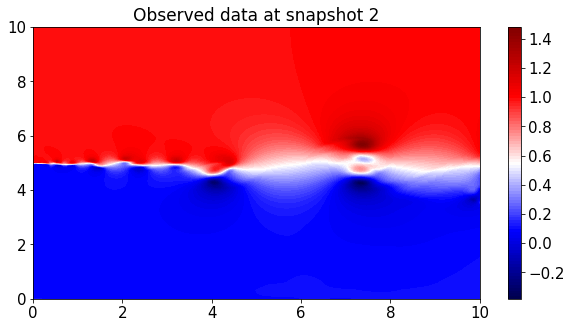

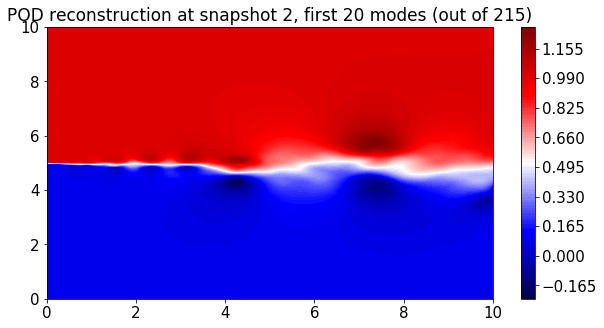

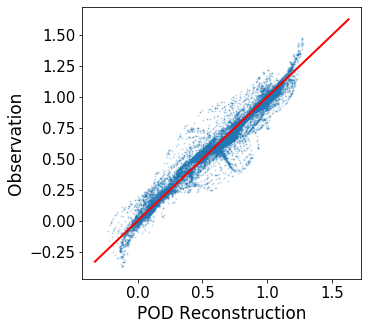

Correlation between the observation and POD reconstruction =  0.9929365317557455


In [25]:
iSnap=2   #snapshot id (for comaprison), iSnap<=m
#Observed snapshot 
if qoiName=='temperature' or qoiName=='pressure':
   Uex=U[:,iSnap]/bmsq
   uRec2_=uRec2[:,iSnap]
elif qoiName=='velocity':
   ##ux
   uRec2_=uRec2[:nxy,iSnap]
   Uex=U[:nxy,iSnap]/bmsq
   ##uy 
   #uRec2_=uRec2[n:,iSnap]
   #Uex=U[n:,iSnap]/bmsq
        
#plot    
contour2d(Uex,x,y,title='Observed data at snapshot %d' %iSnap)
title_='POD reconstruction at snapshot %d, first %d modes (out of %d)' %(iSnap,maxMode,m)
contour2d(uRec2_,x,y,title=title_)
#scatter plot
scatter(uRec2_,Uex,xlab='POD Reconstruction',ylab='Observation')